## Experiment Setup

### Random seed / PyTorch / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Variable settings

#### Data prep

In [4]:
# Dataset to use
uci_dataset_name = 'protein-tertiary-structure'

# Set the proportion of the original dataset to be available as a whole
subset_proportions = [0.01, 0.1, 1]

# Proportion of the dataset to be used for training
dataset_train_size = 0.9

# Number of dataset splits
n_splits = 10

#### NN settings

In [5]:
# Fully-Connected network hidden layers
network_hidden_dims = [25, 50, 100]
network_hidden_layers = [1, 3, 5]

# Dropout
dropout_rates = [0.1, 0.3, 0.5]

# Regularization strengths
reg_strengths = [0.05]


### Training setup

In [6]:
# Epochs
n_epochs = [40, 400, 4000]

# Optimizer learning rate
learning_rate = 0.001 # PyTorch default value is 0.001

# Training data batch sizes
if uci_dataset_name in ('protein-tertiary-structure'): # Note: 45730 rows originally
    n_training_batch = 256
elif uci_dataset_name in ('yacht', 'bostonHousing'):
    n_training_batch = 32

# Number of test predictions (for each data point)
n_prediction = 1000

# Mean Squared Error for loss function to minimize
objective = nn.MSELoss()

# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

## Train the network

In [7]:
for subset_prop, hidden_dim, n_hidden, dropout_rate, reg_strength, n_epoch in itertools.product(
    subset_proportions,
    network_hidden_dims, network_hidden_layers,
    dropout_rates, reg_strengths,
    n_epochs,
):
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)

    # Print parameter combinations being tested
    print(
        "subset %f, n_hidden %d, hidden_dim %d, dropout_rate %f, reg_strength %f"
        % (subset_prop, n_hidden, hidden_dim, dropout_rate, reg_strength))
    
    print("n_epoch %d" % n_epoch)
    print()

    """
    Results file storage
    """

    # Create directory to store results for the current test configuration
    test_results_path = os.path.join(
        './test_results',
        'error_convergence_1',
        uci_dataset_name,
        test_start_time,
        (
            str(subset_prop) 
            + '_' + str(hidden_dim) 
            + '_' + str(n_hidden) 
            + '_' + str(dropout_rate) 
            + '_' + str(reg_strength)
            + '_' + str(n_epoch)),
    )
    
    os.makedirs(test_results_path, exist_ok=True)
    
    test_results_rmse_mc_path = os.path.join(
        test_results_path,
        "rmse_mc.txt"
    )
    
    test_results_lls_mc_path = os.path.join(
        test_results_path,
        "lls_mc.txt"
    )

    test_results_rmse_non_mc_path = os.path.join(
        test_results_path,
        "rmse_non_mc.txt"
    )    

    """
    Dataset multiple splits prep
    """

    # Prepare new subset of the original dataset
    subset = datasets.UCIDatasets(
        uci_dataset_name, root_dir='./datasets_files', 
        limit_size=subset_prop,
        transform=lambda X, mean, std: (X - mean) / std,
        target_transform=lambda y, mean, std: (y - mean) / std,
        download=True)

    # Determine sizes of training and testing set
    train_size = int(dataset_train_size * len(subset))
    test_size = len(subset) - train_size
    
    # Print the size of the subset
    print("subset size = " + str((len(subset), subset.n_features)))
    print("training set size = %d" % train_size)
    print("test set size = %d" % test_size)
    print()
    
    # Prepare multiple sets of random train-test splits 
    # to test the parameter combination
    subset_splits = []

    for _ in range(n_splits):
        train, test = random_split(subset, lengths=[train_size, test_size])
        subset_splits.append((train, test))

    # Try learning with different splits
    for s, (train, test) in enumerate(subset_splits):

        """
        Training
        """
      
        print('Training with split %d' % s)

        train_loader = DataLoader(train, batch_size=n_training_batch, pin_memory=use_pin_memory)

        # Prepare network
        network = models.FCNet(
          input_dim=subset.n_features, 
          output_dim=subset.n_targets,
          hidden_dim=hidden_dim,
          n_hidden=n_hidden,
          dropout_rate=dropout_rate,
          dropout_type='bernoulli',
        )

        # Send the whole model to the selected torch.device
        network.to(torch_device)

        # Model to train mode
        network.train()

        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Record training start time (for this split)
        tic = time.time()

        for epoch in range(n_epoch): # loop over the dataset multiple times
            # Mini-batches
            for data in train_loader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = network(inputs)

                loss = objective(outputs, targets)
                loss.backward()

                optimizer.step()

        # Record training end time
        toc = time.time()

        # Report the final loss
        print("final loss = %f" % (loss.item()))

        """
        Testing
        """

        # Model to eval mode
        network.eval()

        # Get the test data
        inputs, targets = test.dataset[test.indices]

        # Store the batch to torch_device's memory
        inputs = inputs.to(torch_device)
        targets = targets.to(torch_device)

        # Record testing start time
        tic_testing = time.time()

        _, mean, var, metrics = network.predict_dist(
            inputs, n_prediction,
            y_test=targets, reg_strength=reg_strength, train_size=train_size)
        
        # Record testing end time
        toc_testing = time.time()

        # Record all the scores to the score files
        if len(metrics) > 0:
            for key, value in metrics.items():
                print(str(key) + " = " + str(value))

                if key == 'rmse_mc':
                    with open(test_results_rmse_mc_path, 'a+') as rmse_mc_file:
                        rmse_mc_file.write('%d %f \n' % (s, value))

                elif key == 'test_ll_mc':
                    with open(test_results_lls_mc_path, 'a+') as lls_mc_file:
                        lls_mc_file.write('%d %f \n' % (s, value))

                elif key == 'rmse_non_mc':
                    with open(test_results_rmse_non_mc_path, 'a+') as rmse_non_mc_file:
                        rmse_non_mc_file.write('%d %f \n' % (s, value))
                        
        # Report the total training time
        print("training time = " + str(toc - tic) + " seconds")

        # Report the total testing time
        print("testing time = " + str(toc_testing - tic_testing) + " seconds")

        print()

subset 0.010000, n_hidden 1, hidden_dim 25, dropout_rate 0.100000, reg_strength 0.050000
n_epoch 40

Using downloaded and verified file: ./datasets_files/protein-tertiary-structure/data.txt
subset size = (457, 9)
training set size = 411
test set size = 46

Training with split 0
final loss = 0.913619


/Users/se9/Documents/git/bayesian-dl-experiments/ronald_bdl/models/fcnet.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(


rmse_mc = tensor(0.8372)
rmse_non_mc = tensor(0.8350)
test_ll_mc = tensor(-7.4348)
training time = 7.255023002624512 seconds
testing time = 0.8771200180053711 seconds

Training with split 1
final loss = 0.779952
rmse_mc = tensor(0.9281)
rmse_non_mc = tensor(0.9281)
test_ll_mc = tensor(-7.4348)
training time = 6.399428129196167 seconds
testing time = 0.8676919937133789 seconds

Training with split 2
final loss = 0.827453
rmse_mc = tensor(0.9448)
rmse_non_mc = tensor(0.9443)
test_ll_mc = tensor(-7.4348)
training time = 6.536723852157593 seconds
testing time = 1.3835430145263672 seconds

Training with split 3
final loss = 0.728856
rmse_mc = tensor(0.8317)
rmse_non_mc = tensor(0.8322)
test_ll_mc = tensor(-7.4348)
training time = 7.9384729862213135 seconds
testing time = 0.9747509956359863 seconds

Training with split 4
final loss = 0.792936
rmse_mc = tensor(0.9797)
rmse_non_mc = tensor(0.9800)
test_ll_mc = tensor(-7.4348)
training time = 6.195314884185791 seconds
testing time = 1.036840200

final loss = 0.957176
rmse_mc = tensor(1.0984)
rmse_non_mc = tensor(1.0984)
test_ll_mc = tensor(-7.5605)
training time = 4.619536876678467 seconds
testing time = 0.6946051120758057 seconds

Training with split 7
final loss = 0.929379
rmse_mc = tensor(0.9700)
rmse_non_mc = tensor(0.9689)
test_ll_mc = tensor(-7.5605)
training time = 4.619768142700195 seconds
testing time = 0.6573419570922852 seconds

Training with split 8
final loss = 0.898780
rmse_mc = tensor(0.9813)
rmse_non_mc = tensor(0.9774)
test_ll_mc = tensor(-7.5605)
training time = 4.547303915023804 seconds
testing time = 0.7351090908050537 seconds

Training with split 9
final loss = 0.984982
rmse_mc = tensor(0.8754)
rmse_non_mc = tensor(0.8745)
test_ll_mc = tensor(-7.5605)
training time = 4.615163087844849 seconds
testing time = 0.6906449794769287 seconds

subset 0.010000, n_hidden 1, hidden_dim 25, dropout_rate 0.300000, reg_strength 0.050000
n_epoch 400

Using downloaded and verified file: ./datasets_files/protein-tertiary-st

final loss = 0.914077
rmse_mc = tensor(0.8252)
rmse_non_mc = tensor(0.8229)
test_ll_mc = tensor(-7.7287)
training time = 29.857584953308105 seconds
testing time = 0.530379056930542 seconds

Training with split 1
final loss = 0.772537
rmse_mc = tensor(0.9062)
rmse_non_mc = tensor(0.9064)
test_ll_mc = tensor(-7.7287)
training time = 29.220732927322388 seconds
testing time = 0.5266249179840088 seconds

Training with split 2
final loss = 0.852096
rmse_mc = tensor(0.9442)
rmse_non_mc = tensor(0.9409)
test_ll_mc = tensor(-7.7287)
training time = 29.06692099571228 seconds
testing time = 0.5497260093688965 seconds

Training with split 3
final loss = 0.853607
rmse_mc = tensor(0.8307)
rmse_non_mc = tensor(0.8315)
test_ll_mc = tensor(-7.7287)
training time = 29.19127607345581 seconds
testing time = 0.52956223487854 seconds

Training with split 4
final loss = 0.809916
rmse_mc = tensor(0.9761)
rmse_non_mc = tensor(0.9761)
test_ll_mc = tensor(-7.7287)
training time = 31.651077270507812 seconds
testi

final loss = 1.057936
rmse_mc = tensor(0.9019)
rmse_non_mc = tensor(0.9019)
test_ll_mc = tensor(-7.4348)
training time = 29.983235836029053 seconds
testing time = 0.8897461891174316 seconds

Training with split 6
final loss = 1.030668
rmse_mc = tensor(1.1619)
rmse_non_mc = tensor(1.1619)
test_ll_mc = tensor(-7.4348)
training time = 29.93454909324646 seconds
testing time = 0.9129762649536133 seconds

Training with split 7
final loss = 0.678593
rmse_mc = tensor(0.9281)
rmse_non_mc = tensor(0.9283)
test_ll_mc = tensor(-7.4348)
training time = 29.712249040603638 seconds
testing time = 0.8795020580291748 seconds

Training with split 8
final loss = 0.686400
rmse_mc = tensor(0.8646)
rmse_non_mc = tensor(0.8636)
test_ll_mc = tensor(-7.4348)
training time = 29.72945785522461 seconds
testing time = 0.8807992935180664 seconds

Training with split 9
final loss = 1.079082
rmse_mc = tensor(0.9172)
rmse_non_mc = tensor(0.9172)
test_ll_mc = tensor(-7.4348)
training time = 30.419989347457886 seconds
te

subset size = (457, 9)
training set size = 411
test set size = 46

Training with split 0
final loss = 1.077157
rmse_mc = tensor(0.9382)
rmse_non_mc = tensor(0.9382)
test_ll_mc = tensor(-7.5605)
training time = 321.52305698394775 seconds
testing time = 1.1201562881469727 seconds

Training with split 1
final loss = 0.981327
rmse_mc = tensor(0.9482)
rmse_non_mc = tensor(0.9481)
test_ll_mc = tensor(-7.5605)
training time = 312.02744007110596 seconds
testing time = 1.3689980506896973 seconds

Training with split 2
final loss = 0.918873
rmse_mc = tensor(1.0097)
rmse_non_mc = tensor(1.0097)
test_ll_mc = tensor(-7.5605)
training time = 315.92695689201355 seconds
testing time = 1.094313144683838 seconds

Training with split 3
final loss = 0.949393
rmse_mc = tensor(0.8769)
rmse_non_mc = tensor(0.8769)
test_ll_mc = tensor(-7.5605)
training time = 313.2013158798218 seconds
testing time = 1.0993549823760986 seconds

Training with split 4
final loss = 0.871144
rmse_mc = tensor(1.0293)
rmse_non_mc = 

final loss = 1.056183
rmse_mc = tensor(0.9012)
rmse_non_mc = tensor(0.9013)
test_ll_mc = tensor(-7.7287)
training time = 317.3448398113251 seconds
testing time = 1.0768766403198242 seconds

Training with split 6
final loss = 1.031303
rmse_mc = tensor(1.1607)
rmse_non_mc = tensor(1.1607)
test_ll_mc = tensor(-7.7287)
training time = 319.3178482055664 seconds
testing time = 1.1474790573120117 seconds

Training with split 7
final loss = 0.968635
rmse_mc = tensor(0.9659)
rmse_non_mc = tensor(0.9658)
test_ll_mc = tensor(-7.7287)
training time = 319.42299604415894 seconds
testing time = 1.0822820663452148 seconds

Training with split 8
final loss = 1.004892
rmse_mc = tensor(1.0780)
rmse_non_mc = tensor(1.0780)
test_ll_mc = tensor(-7.7287)
training time = 403.3098101615906 seconds
testing time = 2.581209182739258 seconds

Training with split 9
final loss = 1.081809
rmse_mc = tensor(0.9162)
rmse_non_mc = tensor(0.9161)
test_ll_mc = tensor(-7.7287)
training time = 726.8979389667511 seconds
testi

subset size = (457, 9)
training set size = 411
test set size = 46

Training with split 0
final loss = 1.087284
rmse_mc = tensor(0.9392)
rmse_non_mc = tensor(0.9396)
test_ll_mc = tensor(-7.5605)
training time = 3.258042097091675 seconds
testing time = 1.2756719589233398 seconds

Training with split 1
final loss = 0.972987
rmse_mc = tensor(0.9540)
rmse_non_mc = tensor(0.9538)
test_ll_mc = tensor(-7.5605)
training time = 3.273305892944336 seconds
testing time = 1.5291128158569336 seconds

Training with split 2
final loss = 0.923911
rmse_mc = tensor(1.0098)
rmse_non_mc = tensor(1.0098)
test_ll_mc = tensor(-7.5605)
training time = 3.205420970916748 seconds
testing time = 1.257260799407959 seconds

Training with split 3
final loss = 0.940744
rmse_mc = tensor(0.8778)
rmse_non_mc = tensor(0.8775)
test_ll_mc = tensor(-7.5605)
training time = 3.3345608711242676 seconds
testing time = 1.516197919845581 seconds

Training with split 4
final loss = 0.873921
rmse_mc = tensor(1.0296)
rmse_non_mc = ten

KeyboardInterrupt: 

## Results visualization

In [ ]:
# experiment_root_directory = os.path.join(
#     './test_results',
#     'error_convergence_1',
#     uci_dataset_name,
#     test_start_time,
# )

# for subset_prop, dropout_rate, reg_strength, n_epoch in itertools.product(
#     subset_proportions, dropout_rates, reg_strengths, n_epochs
# ):
#     for metric_name in ['lls_mc', 'rmse_mc', 'rmse_non_mc']:
#         figure_file_name = (
#             str(subset_prop)
#             + '_' + str(dropout_rate)
#             + '_' + str(reg_strength)
#             + '_' + str(n_epoch)
#             + '_' + metric_name + '.png'
#         )
        
#         figure_title = (
#             metric_name 
#             + (' subset %f, dropout rate = %f, reg strength = %f, n_epoch = %d' % (subset_prop, dropout_rate, reg_strength, n_epoch))
#         )

#         fig, ax = plt.subplots(len(network_hidden_dims), len(network_hidden_layers))

#         fig.tight_layout(pad=2, rect=[0, 0.00, 2, 2])    

#         plt_subplot_current_row = 0
        
#         for hidden_dim in network_hidden_dims:
#             plt_subplot_current_column = 0

#             for n_layer in network_hidden_layers:
#                 # Open the score file
#                 score_file_path = os.path.join(
#                     experiment_root_directory,
#                     (
#                         str(subset_prop) 
#                         + '_' + str(hidden_dim)
#                         + '_' + str(n_layer) 
#                         + '_' + str(dropout_rate) 
#                         + '_' + str(reg_strength)
#                         + '_' + str(n_epoch)
#                     ),
#                     metric_name + '.txt',
#                 )

#                 scores = np.loadtxt(score_file_path).T
                
#                 #if metric_name in ('rmse_mc', 'rmse_non_mc'):
#                 #    ax[plt_subplot_current_row, plt_subplot_current_column].set_ylim([0, 20])
#                 #elif metric_name == 'lls_mc':
#                 #    ax[plt_subplot_current_row, plt_subplot_current_column].set_ylim([-20, 0])

#                 ax[plt_subplot_current_row, plt_subplot_current_column].scatter(scores[0], scores[1])

#                 ax[plt_subplot_current_row, plt_subplot_current_column].set_title(str((hidden_dim, n_layer)))

#                 plt_subplot_current_column += 1

#             plt_subplot_current_row += 1

#         fig.suptitle(figure_title, y=2.05)
        
#         plt.savefig(
#             os.path.join(experiment_root_directory, figure_file_name),
#             dpi=600,
#             bbox_inches='tight',
#         )
        
#         plt.show()

OSError: ./test_results/error_convergence_1/protein-tertiary-structure/201912030108/0.01_50_1_0.1_0.05_40/lls_mc.txt not found.

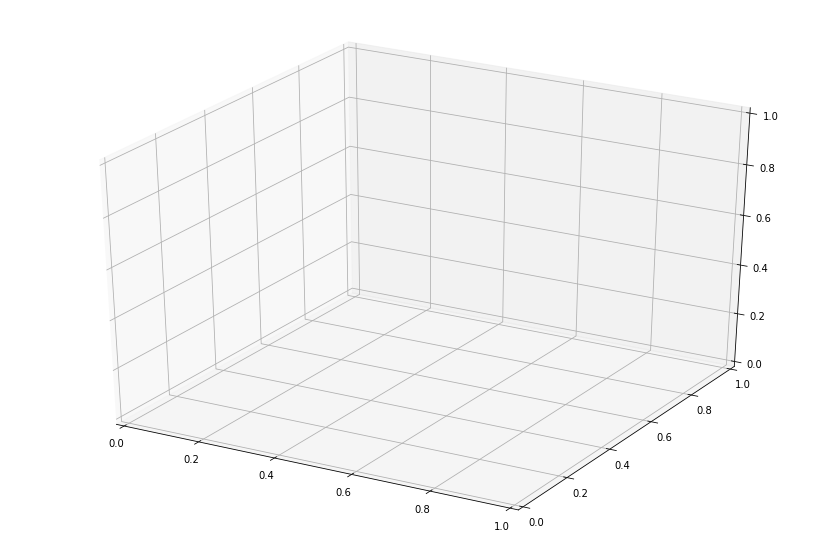

In [8]:
from mpl_toolkits.mplot3d import Axes3D

experiment_root_directory = os.path.join(
    './test_results',
    'error_convergence_1',
    uci_dataset_name,
    test_start_time,
)

for subset_prop, dropout_rate, reg_strength, n_epoch in itertools.product(
    subset_proportions, dropout_rates, reg_strengths, n_epochs
):
    for metric_name in ['lls_mc', 'rmse_mc', 'rmse_non_mc']:
        figure_file_name = (
            '3d_' + str(subset_prop)
            + '_' + str(dropout_rate)
            + '_' + str(reg_strength)
            + '_' + str(n_epoch)
            + '_' + metric_name + '.png'
        )
        
        figure_title = (
            metric_name 
            + (' subset %f, dropout rate = %f, reg strength = %f, n_epoch = %d' 
               % (subset_prop, dropout_rate, reg_strength, n_epoch))
        )

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        fig.tight_layout(pad=2, rect=[0, 0.00, 2, 2])
        
        hidden_dims_data = []
        hidden_layers_data = []
        scores_data = []
        
        for hidden_dim in network_hidden_dims:
            for n_layer in network_hidden_layers:
                # Open the score file
                score_file_path = os.path.join(
                    experiment_root_directory,
                    (
                        str(subset_prop) 
                        + '_' + str(hidden_dim)
                        + '_' + str(n_layer) 
                        + '_' + str(dropout_rate) 
                        + '_' + str(reg_strength)
                        + '_' + str(n_epoch)
                    ),
                    metric_name + '.txt',
                )

                scores = np.loadtxt(score_file_path).T
                
                for s in scores[1]:
                    # Multiple values (for each split) for
                    # each (hidden_dim, n_layer) combination
                    hidden_dims_data.append(hidden_dim)
                    hidden_layers_data.append(n_layer)
                    scores_data.append(s)
                    
                mean = np.mean(scores[1])
                var = np.var(scores[1])

        ax.set_xlabel('hidden layer units')
        ax.set_ylabel('number of hidden layers')
        
        #if metric_name in ('rmse_mc', 'rmse_non_mc'):
        #    ax.set_zlim([0, 5])
        #elif metric_name == 'lls_mc':
        #    ax.set_zlim([-5, 0])
    
        ax.scatter3D(hidden_dims_data, hidden_layers_data, scores_data, c=scores_data)

        fig.suptitle(figure_title, y=2.05)        
        
        plt.savefig(
            os.path.join(experiment_root_directory, figure_file_name),
            dpi=300,
            bbox_inches='tight',
        )
        
        plt.show()